In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.utils.data
import torchvision.datasets as dset
import torchvision.utils as vutils
import torch.backends.cudnn as cudnn
import matplotlib.pyplot as plt
from tqdm import tqdm
from tqdm.autonotebook import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
import os
import glob
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

from PIL import Image


class MySampler(torch.utils.data.Sampler):
    def __init__(self, end_idx, seq_length):        
        indices = []
        for i in range(len(end_idx)-1):
            start = end_idx[i]
            end = start + 4*seq_length[i] 
            indices.append(torch.arange(start, end))
        
        random.shuffle(indices)
        self.indices = indices
    def __iter__(self):
        indices = self.indices
        return iter(indices)
    
    def __len__(self):
        return len(self.indices)

def getIndex(index,indlist):
    for i in range (len(indlist)) :
        if indlist[i]>index:
            return i
class MyDataset(Dataset):
    def __init__(self, image_paths, seq_length, transform, length,indicese):
        self.image_paths = image_paths
        self.seq_length = seq_length
        self.transform = transform
        self.length = length
        self.indicese=indicese
    def __getitem__(self, index):
        if (len(index)==0):
            return -1,-1
        start = int(index[0])        
        end = int(index[-1])+1
        end=int(end)
        listPath=self.image_paths[start:end]
        indices = list(range(start, end))
        
        images = []
        lenSeq=len(listPath)/4
        lenSeq=int(lenSeq)
        for i in range(lenSeq):
            img=[]
            for j in range (4):
                #j correspond au num channel
                image_path = listPath[(j*lenSeq)+i][0]
                image = Image.open(image_path)
                if self.transform:
                    image = self.transform(image)
                img.append(image)    
            images.append(img)
        
        x = images
        y = torch.tensor([self.image_paths[start][1]], dtype=torch.long)
        
        return x, y
    
    def __len__(self):
        return self.length




In [ ]:
from google.colab import drive
drive.mount("/content/drive")
path = os.getcwd()
print("Le répertoire courant est : " + path)



Mounted at /content/drive
Le répertoire courant est : /content


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile("/content/drive/My Drive/image_set.zip", 'r')
zip_ref.extractall("/data2")
zip_ref.close()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

root_dir = '../data2/image_set'
class_paths = sorted([d.path for d in os.scandir(root_dir) if d.is_dir])
bon=[]
bon.extend(class_paths[:2])
bon.extend(class_paths[4:])
bon.extend(class_paths[2:4])

class_paths =bon
def getData(class_paths,split_ratio):
  train_end_idx=[]
  train_seq_length=[]
  train_class_image_paths=[]

  test_end_idx=[]
  test_seq_length=[]
  test_class_image_paths=[]

  for c, class_path in enumerate(class_paths):
      l=sorted([d.path for d in os.scandir(class_path) if d.is_dir])
      random.shuffle(l)
      train_size=int(len(l)*split_ratio)
      train_p=sorted(l[:train_size])
      test_p=sorted(l[train_size:])
      
      for d in train_p:
            paths = sorted(glob.glob(os.path.join(d, '*.jpg')))
            paths = sorted([(p, c) for p in paths])
            train_class_image_paths.extend(paths)
            train_end_idx.extend([len(paths)])
            train_seq_length.append(len(paths)/4)
      for d in test_p:
            paths = sorted(glob.glob(os.path.join(d, '*.jpg')))
            paths = sorted([(p, c) for p in paths])
            test_class_image_paths.extend(paths)
            test_end_idx.extend([len(paths)])
            test_seq_length.append(len(paths)/4)

  
  train_end_idx = [0, *train_end_idx]
  train_end_idx = torch.cumsum(torch.tensor(train_end_idx), 0)

  test_end_idx = [0, *test_end_idx]
  test_end_idx = torch.cumsum(torch.tensor(test_end_idx), 0)
  return train_end_idx,train_seq_length,train_class_image_paths,test_end_idx,test_seq_length,test_class_image_paths


train_end_idx,train_seq_length,train_class_image_paths,test_end_idx,test_seq_length,test_class_image_paths=getData(class_paths,0.5)


train_sampler = MySampler(train_end_idx, train_seq_length)
test_sampler = MySampler(test_end_idx, test_seq_length)



12
476
476
476
476
476
475
475
475
475
476
476
276


4400
1108


In [ ]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor()
])

train_dataset = MyDataset(
    image_paths=train_class_image_paths,
    seq_length=train_seq_length,
    transform=transform,
    length=len(train_sampler),
    indicese=train_end_idx.tolist())

test_dataset = MyDataset(
    image_paths=test_class_image_paths,
    seq_length=test_seq_length,
    transform=transform,
    length=len(test_sampler),
    indicese=test_end_idx.tolist())



'split_ratio=0.8\ntrain_size=int(split_ratio*len(dataset))\ntest_size=len(dataset)-train_size\nprint(train_size,test_size)\ntrain_set,test_set=torch.utils.data.random_split(dataset, [train_size, test_size])\n\n'

In [ ]:
trainloader = DataLoader(train_dataset,sampler=train_sampler)

testloader = DataLoader(test_dataset,sampler=test_sampler)



2752
2756


In [ ]:
def train(nbEpochs=10):
    print(net)
    train_loss=[]
    test_loss=[]
    accura=[]
    criterion = nn.CrossEntropyLoss()
    for epoch in range(nbEpochs):  
      
        tloss = 0.0
        
        i=0
        t = tqdm(iter(trainloader), total=len(trainloader), dynamic_ncols=True)
        qt=0
        for d,l in t:
            if (d!=-1)>0:
                    j=0
                    inputs=[]
                    labels=[]
                    batch_size=len(d)
                    for i in range(batch_size):
                      inputs.append(torch.stack(d[i]))
                      labels.append(l)
                    qt+=1
                    inputs=torch.stack(inputs)
                    inputs=inputs.reshape(batch_size,4,32,32)
                    labels=torch.stack(labels)
                    labels=labels.reshape(batch_size)
                    inputs, labels = inputs.to(device), labels.to(device)
                    optimizer.zero_grad() 
                    outputs = net(inputs)
                    loss = criterion(outputs, labels)                                      
                    loss.backward()
                    optimizer.step()
                    tloss += loss.item()

        tloss=tloss/qt
        print("train loss=",epoch, tloss) 
        train_loss.append(tloss)
        tloss=0.0
        ok = 0
        tot = 0
        qt=0
        with torch.no_grad():
            t = tqdm(iter(testloader), total=len(testloader))
            for d,l in t:
                if (d!=-1)>0:
                        j=0
                        inputs=[]
                        labels=[]
                        batch_size=len(d)
                        for i in range(batch_size):
                          inputs.append(torch.stack(d[i]))
                          labels.append(l)
                        qt+=1
                        inputs=torch.stack(inputs)
                        inputs=inputs.reshape(batch_size,4,32,32)
                        labels=torch.stack(labels)
                        labels=labels.reshape(batch_size)
                        inputs, labels = inputs.to(device), labels.to(device)

                        outputs = net(inputs)
                        loss = criterion(outputs, labels)
                        _, predicted = torch.max(outputs.data, 1)
                        f=predicted.cpu().detach().numpy()
                        a=np.array(f)
                        counts = np.bincount(a)
                        pred=np.argmax(counts)
                        
                        tot += 1
                        ok += (pred == l)
                        
                        tloss += loss.item()
        
        tloss=tloss/qt
        print("test loss=",epoch, tloss) 
        test_loss.append(tloss)
        print('Accuracy in test', (100.0 * ok.item() / tot))
        accura.append((100.0 * ok.item() / tot))
    cnn_nb_epoch=np.arange(10)
    plt.plot(cnn_nb_epoch,train_loss,label="train_loss")
    plt.plot(cnn_nb_epoch,test_loss,label="test_loss")
    plt.xlabel('numéro d\'epoch')
    plt.legend()
    plt.show()
    plt.plot(cnn_nb_epoch,accura)
    plt.xlabel('numéro d\'epoch')
    plt.ylabel('accuracy')
    plt.show()



In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(4,32,1)
        self.pool = nn.MaxPool2d(3, 1)
        self.conv2 = nn.Conv2d(32, 64, 1)
        self.pool2 = nn.MaxPool2d(3, 1)
        self.conv3 = nn.Conv2d(64, 128, 3)
        self.pool3 = nn.MaxPool2d(3, 1)

        
        self.fc1 = nn.Linear(73728, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 12)

    def forward(self, x):
        
        x=self.conv1(x)
        x = self.pool(F.relu(x))
        x=self.conv2(x)
        x = self.pool2(F.relu(x))
        x=self.conv3(x)
        x = self.pool3(F.relu(x))
        x = x.view(x.size()[0], -1)
      #  print(x.shape)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
      
net=Net()
learning_rate = 1e-4
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
net.to(device)
train()


Net(
  (conv1): Conv2d(4, 32, kernel_size=(1, 1), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=73728, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=12, bias=True)
)


erreur
erreur
erreur
erreur
erreur

train loss= 0 1.7831949060928574


erreur
erreur
erreur

test loss= 0 1.3417090737249715
Accuracy in test 71.30403196512896


erreur
erreur
erreur
erreur
erreur

train loss= 1 1.2606026885809305


erreur
erreur
erreur

test loss= 1 1.1441771928146562
Accuracy in test 78.53250998910279


erreur
erreur
erreur
erreur
erreur

train loss= 2 1.1068112299003556


erreur
erreur
erreur

test loss= 2 1.0603680979207435
Accuracy in test 80.85724664002906


erreur
erreur
erreur
erreur
erreur

train loss= 3 1.0178516250820597


erreur
erreur
erreur

test loss= 3 0.9895262100767308
Accuracy in test 82.56447511805304


erreur
erreur
erreur
erreur
erreur

train loss= 4 0.9523732803716952


erreur
erreur
erreur

test loss= 4 0.9456214234490006
Accuracy in test 83.76316745368689


erreur
erreur
erreur
erreur
erreur

train loss= 5 0.9031625255778719


erreur
erreur
erreur

test loss= 5 0.9131133811194159
Accuracy in test 84.78023973846713


erreur
erreur
erreur
erreur
erreur

train loss= 6 0.8614929244253849


erreur
erreur
erreur

test loss= 6 0.884392317333822
Accuracy in test 85.6883399927352


erreur
erreur
erreur
erreur
erreur

train loss= 7 0.8266395341031156


erreur
erreur
erreur

test loss= 7 0.8594354397809769
Accuracy in test 86.19687613512532


erreur
erreur
erreur
erreur
erreur

train loss= 8 0.796152884641828


erreur
erreur
erreur

test loss= 8 0.8357208610073464
Accuracy in test 86.77806029785688


erreur
erreur
erreur
erreur
erreur

train loss= 9 0.7692831389090754


erreur
erreur
erreur

test loss= 9 0.8157741824117033
Accuracy in test 87.35924446058844


NameError: ignored

In [ ]:

def train2(nbEpochs=10):

    print(rnn)
    train_loss=[]
    test_loss=[]
    accura=[]
    criterion = nn.CrossEntropyLoss()
    for epoch in range(nbEpochs):  
        tloss = 0.0      
        i=0
        t = tqdm(iter(trainloader), total=len(trainloader), dynamic_ncols=True)
        qt=0
        for d,l in t:
            if (d!=-1)>0:
                    j=0
                    inputs=[]
                    batch_size=len(d)
                    for i in range(batch_size):
                      inputs.append(torch.stack(d[i]))
                      
                    qt+=1
                    inputs=torch.stack(inputs)
                    inputs=inputs.reshape(1,batch_size,-1)
                    labels=torch.tensor([l.item()])                    
                    inputs, labels = inputs.to(device), labels.to(device)
                    optimizer.zero_grad() 
                    outputs = rnn(inputs)
                    loss = criterion(outputs, labels)
                    #backward and optimize
                                      
                    loss.backward()
                    optimizer.step()
                    tloss += loss.item()

        tloss=tloss/qt
        print("train loss=",epoch, tloss) 
        train_loss.append(tloss)
        tloss=0.0
        ok = 0
        tot = 0
        qt=0
        with torch.no_grad():
            t = tqdm(iter(testloader), total=len(testloader))
            for d,l in t:
                if (d!=-1)>0:
                        j=0
                        inputs=[]
                        batch_size=len(d)
                        for i in range(batch_size):
                          inputs.append(torch.stack(d[i]))
                        
                        qt+=1

                        inputs=torch.stack(inputs)
                        inputs=inputs.reshape(1,batch_size,-1)

                        labels=torch.tensor([l.item()])
                        inputs, labels = inputs.to(device), labels.to(device)
                        
                        outputs = rnn(inputs)
                        loss = criterion(outputs, labels)
                        _, predicted = torch.max(outputs.data, 1)
                        tot += labels.size(0)
                        ok += (predicted == labels).sum().item()
                        tloss += loss.item()
        
        tloss=tloss/qt
        print("test loss=",epoch, tloss) 
        test_loss.append(tloss)   
        print('Accuracy in test', (100.0 * ok / tot))
        accura.append((100.0 * ok / tot))
    rnn_nb_epoch=np.arange(10)
    plt.plot(rnn_nb_epoch,train_loss,label="train_loss")
    plt.plot(rnn_nb_epoch,test_loss,label="test_loss")
    plt.xlabel('numéro d\'epoch')
    plt.legend()
    plt.show()
    plt.plot(rnn_nb_epoch,accura)
    plt.xlabel('numéro d\'epoch')
    plt.ylabel('accuracy')
    plt.show()

RNN(
  (gru): GRU(4096, 512, num_layers=2, batch_first=True)
  (fc): Linear(in_features=512, out_features=12, bias=True)
)


erreur
erreur
erreur
erreur
erreur

train loss= 0 0.7893003286048497


erreur
erreur
erreur

test loss= 0 0.2742164698379084
Accuracy in test 90.4467853250999


erreur
erreur
erreur
erreur
erreur

train loss= 1 0.24056755976533004


erreur
erreur
erreur

test loss= 1 0.18140889797643422
Accuracy in test 93.60697420995278


erreur
erreur
erreur
erreur
erreur

train loss= 2 0.1676909286162423


erreur
erreur
erreur

test loss= 2 0.2178745996199863
Accuracy in test 92.55357791500181


erreur
erreur
erreur
erreur
erreur

train loss= 3 0.10841987924703511


erreur
erreur
erreur

test loss= 3 0.17824818645906298
Accuracy in test 93.60697420995278


erreur
erreur
erreur
erreur
erreur

train loss= 4 0.09520988342808683


erreur
erreur
erreur

test loss= 4 0.10344313340291318
Accuracy in test 96.25862695241554


erreur
erreur
erreur
erreur
erreur

train loss= 5 0.06962648021641199


erreur
erreur
erreur

test loss= 5 0.116410960344744
Accuracy in test 96.18597893207411


erreur
erreur
erreur
erreur
erreur

train loss= 6 0.04807758158751075


erreur
erreur
erreur

test loss= 6 0.06988052610311737
Accuracy in test 97.71158735924446


erreur
erreur
erreur
erreur
erreur

train loss= 7 0.05398272588582744


erreur
erreur
erreur

test loss= 7 0.0659343200492777
Accuracy in test 97.78423537958591


erreur
erreur
erreur
erreur
erreur

train loss= 8 0.028792050567479525


erreur
erreur
erreur

test loss= 8 0.07876890547417666
Accuracy in test 97.96585543043952


erreur
erreur
erreur
erreur
erreur

train loss= 9 0.03670647724305393


erreur
erreur
erreur

test loss= 9 0.06515702286944616
Accuracy in test 98.14747548129313


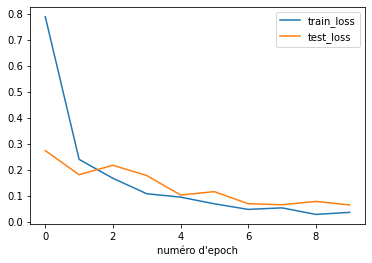

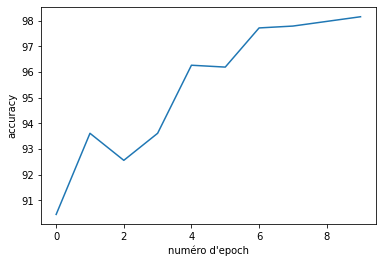

In [ ]:
class RNN(nn.Module):
    def __init__(self,input_size=4*32*32,hidden_size=512,num_classes=12,num_layers=2):
        super(RNN, self).__init__()
        self.num_layers=num_layers
        self.hidden_size=hidden_size
        self.gru=nn.GRU(input_size,hidden_size,num_layers,batch_first=True)
        #x->(batch_size,seq,input_size)
        self.fc=nn.Linear(hidden_size,num_classes)


    def forward(self, x):
        h0 =torch.zeros(self.num_layers,x.size(0),self.hidden_size).to(device)
        c0 =torch.zeros(self.num_layers,x.size(0),self.hidden_size).to(device)
        out,_=self.gru(x,h0)
        #out-> batch_size,seq_length,hidden_size
        out=out[:,-1,:]
        out=self.fc(out)
        return out


rnn=RNN()
learning_rate = 1e-4
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
rnn.to(device)
train2()


In [ ]:
class CNNRNN(nn.Module):
    def __init__(self,input_size=512,hidden_size=512,num_classes=12,num_layers=2):
        super(CNNRNN, self).__init__()
        self.num_layers=num_layers
        self.hidden_size=hidden_size

        self.conv1 = nn.Conv2d(4,32,1)
        self.pool = nn.MaxPool2d(3, 1)
        self.conv2 = nn.Conv2d(32, 64, 1)
        self.pool2 = nn.MaxPool2d(3, 1)
        self.conv3 = nn.Conv2d(64, 128, 3)
        self.pool3 = nn.MaxPool2d(3, 1)

        
        self.fc1 = nn.Linear(73728, 512)
        self.fc2 = nn.Linear(512, 512)



        self.gru=nn.GRU(512,hidden_size,num_layers,batch_first=True)
        #x->(batch_size,seq,input_size)
        self.fc=nn.Linear(hidden_size,num_classes)


    def forward(self, x):
        x1=x.reshape(1,x.size()[1],4,32,32)
        res=[]
        for i in range (x1.size()[1]):
          x=x1[0][i]
          x=x.reshape(1,4,32,32)
          x=self.conv1(x)
          x = self.pool(F.relu(x))
          x=self.conv2(x)
          x = self.pool2(F.relu(x))
          x=self.conv3(x)
          x = self.pool3(F.relu(x))
          x = x.view(x.size()[0], -1)
        #  print(x.shape)
          x = F.relu(self.fc1(x))
          x = F.relu(self.fc2(x))
          x = x.view(x.size()[0], -1)
          x=x.reshape(512)
          res.append(x)
          
        res=torch.stack(res)
        res=res.reshape(1,res.size()[0],-1)
        h0 =torch.zeros(self.num_layers,res.size(0),self.hidden_size).to(device)
        out,_=self.gru(res,h0)
        out=out[:,-1,:]
        out=self.fc(out)
        return out


rnn=CNNRNN()
learning_rate = 1e-4
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
rnn.to(device)
train2()

CNNRNN(
  (conv1): Conv2d(4, 32, kernel_size=(1, 1), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=73728, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (gru): GRU(512, 512, num_layers=2, batch_first=True)
  (fc): Linear(in_features=512, out_features=12, bias=True)
)


erreur
erreur
erreur
erreur
erreur

train loss= 0 1.3874699868750275


erreur
erreur
erreur

test loss= 0 0.5585841061586408
Accuracy in test 77.62440973483473


erreur
erreur
erreur
erreur
erreur

train loss= 1 0.43985639100308366


erreur
erreur
erreur

test loss= 1 0.3010989694130446
Accuracy in test 89.32074100980748


erreur
erreur
erreur
erreur
erreur

train loss= 2 0.24086488728291097


erreur
erreur
erreur

test loss= 2 0.1642614563172284
Accuracy in test 94.95096258626953


erreur
erreur
erreur
erreur
erreur

train loss= 3 0.16236362990745015


erreur
erreur
erreur

test loss= 3 0.1470285794733014
Accuracy in test 95.60479476934253


erreur
erreur
erreur
erreur
erreur

train loss= 4 0.13421501237325537


erreur
erreur
erreur

test loss= 4 0.12455493384616513
Accuracy in test 95.24155466763531


erreur
erreur
erreur
erreur
erreur

train loss= 5 0.11326312867064883


erreur
erreur
erreur

test loss= 5 0.10978143752705037
Accuracy in test 96.14965492190338


erreur
erreur
erreur
erreur
erreur

train loss= 6 0.08785653937007809


erreur
erreur
